In [1]:
import os
import zipfile
import random
import shutil
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

from shutil import copyfile

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
defect_zip ='./drive/MyDrive/CoffeeBeans/defect2.zip'
zip_ref = zipfile.ZipFile(defect_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

In [4]:
normal_zip = './drive/MyDrive/CoffeeBeans/normal2.zip'
zip_ref = zipfile.ZipFile(normal_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

In [5]:
source_path = '/tmp'

source_path_defect = os.path.join(source_path, 'defect')
source_path_normal = os.path.join(source_path, 'normal')

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_defect))} images of defect coffee beans.")
print(f"There are {len(os.listdir(source_path_normal))} images of normal coffee beans.")

There are 1600 images of defect coffee beans.
There are 4050 images of normal coffee beans.


In [6]:
# grader-required-cell

# Define root directory
root_dir = '/tmp/coffee-beans-classification'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

# GRADED FUNCTION: create_train_val_dirs
def create_train_val_dirs(root_path):
  """
  Creates directories for the train and test sets
  
  Args:
    root_path (string) - the base directory path to create subdirectories from
  
  Returns:
    None
  """

  os.makedirs(os.path.join(root_path, 'training'))
  os.makedirs(os.path.join(f'{root_path}/training', 'normal'))
  os.makedirs(os.path.join(f'{root_path}/training', 'defect'))
  os.makedirs(os.path.join(root_path, 'validation'))
  os.makedirs(os.path.join(f'{root_path}/validation', 'normal'))
  os.makedirs(os.path.join(f'{root_path}/validation', 'defect'))

  ### END CODE HERE

  
try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [7]:
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/coffee-beans-classification/validation
/tmp/coffee-beans-classification/training
/tmp/coffee-beans-classification/validation/defect
/tmp/coffee-beans-classification/validation/normal
/tmp/coffee-beans-classification/training/defect
/tmp/coffee-beans-classification/training/normal


In [8]:
# grader-required-cell

# GRADED FUNCTION: split_data
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  """
  Splits the data into train and test sets
  
  Args:
    SOURCE_DIR (string): directory path containing the images
    TRAINING_DIR (string): directory path to be used for training
    VALIDATION_DIR (string): directory path to be used for validation
    SPLIT_SIZE (float): proportion of the dataset to be used for training
    
  Returns:
    None
  """

  ### START CODE HERE
  shuffled_list = random.sample(os.listdir(SOURCE_DIR), len(os.listdir(SOURCE_DIR)))

  training_number = int(len(shuffled_list) * SPLIT_SIZE)
  i = 0
  target = TRAINING_DIR

  for item in shuffled_list:
    item_source = os.path.join(SOURCE_DIR, item)
    if os.path.getsize(item_source) != 0:
      copyfile(item_source, os.path.join(target, item))
      i+=1
    else:
      print(f'{item} is zero length, so ignoring.')
      
    if i == training_number:
        target = VALIDATION_DIR
  ### END CODE HERE

In [9]:
# grader-required-cell

# Test your split_data function

# Define paths
DEFECT_SOURCE_DIR = "/tmp/defect/"
NORMAL_SOURCE_DIR = "/tmp/normal/"

TRAINING_DIR = "/tmp/coffee-beans-classification/training/"
VALIDATION_DIR = "/tmp/coffee-beans-classification/validation/"

TRAINING_DEFECT_DIR = os.path.join(TRAINING_DIR, "defect/")
VALIDATION_DEFECT_DIR = os.path.join(VALIDATION_DIR, "defect/")

TRAINING_NORMAL_DIR = os.path.join(TRAINING_DIR, "normal/")
VALIDATION_NORMAL_DIR = os.path.join(VALIDATION_DIR, "normal/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_DEFECT_DIR)) > 0:
  for file in os.scandir(TRAINING_DEFECT_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_NORMAL_DIR)) > 0:
  for file in os.scandir(TRAINING_NORMAL_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_DEFECT_DIR)) > 0:
  for file in os.scandir(VALIDATION_DEFECT_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_NORMAL_DIR)) > 0:
  for file in os.scandir(VALIDATION_NORMAL_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .95

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(DEFECT_SOURCE_DIR, TRAINING_DEFECT_DIR, VALIDATION_DEFECT_DIR, split_size)
split_data(NORMAL_SOURCE_DIR, TRAINING_NORMAL_DIR, VALIDATION_NORMAL_DIR, split_size)

# Check that the number of images matches the expected output

# Your function should perform copies rather than moving images so original directories should contain unchanged images
print(f"Original defect coffee beans directory has {len(os.listdir(DEFECT_SOURCE_DIR))} images")
print(f"Original nromal coffee beans directory has {len(os.listdir(NORMAL_SOURCE_DIR))} images\n")

# Training and validation splits
print(f"There are {len(os.listdir(TRAINING_DEFECT_DIR))} images of defect coffee beans for training")
print(f"There are {len(os.listdir(TRAINING_NORMAL_DIR))} images of normal coffee beans for training")
print(f"There are {len(os.listdir(VALIDATION_DEFECT_DIR))} images of defect coffee beans for validation")
print(f"There are {len(os.listdir(VALIDATION_NORMAL_DIR))} images of normal coffee beans for validation")

Original defect coffee beans directory has 1600 images
Original nromal coffee beans directory has 4050 images

There are 1520 images of defect coffee beans for training
There are 3847 images of normal coffee beans for training
There are 80 images of defect coffee beans for validation
There are 203 images of normal coffee beans for validation


# Transfer Learning

In [10]:
def train_val_generators3(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators
  
  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images
    
  Returns:
    train_generator, validation_generator - tuple containing the generators
  """

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale=1./255,
      # zoom_range=0.2,
      # horizontal_flip=True,
      fill_mode='nearest' )

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=16,
                                                      class_mode="binary",
                                                      target_size=(224, 224))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=16,
                                                                class_mode="binary",
                                                                target_size=(224, 224))
  ### END CODE HERE
  return train_generator, validation_generator

In [11]:
train_generator3, validation_generator3 = train_val_generators3(TRAINING_DIR, VALIDATION_DIR)

Found 5367 images belonging to 2 classes.
Found 283 images belonging to 2 classes.


In [12]:
def create_model_tl():

  model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer((224,224,3), dtype=tf.float32),
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", trainable=False),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1)
  ]);
  
  # from tensorflow.keras.optimizers import RMSprop
  
  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                loss="binary_crossentropy",
                metrics=['accuracy']) 
    
  ### END CODE HERE

  return model

In [13]:
class Callback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') > 0.93) and (logs.get('val_accuracy') > 0.93):
            print("\n Training accuracy has been over 93% so sop training") 
            self.model.stop_training = True 
 
callbacks = Callback()

In [14]:
# Get the untrained model
model_tl = create_model_tl()

# Train the model
# Note that this may take some time.
history = model_tl.fit(train_generator3,
                    epochs=25,
                    validation_data=validation_generator3,
                    callbacks=callbacks)

Epoch 1/25
336/336 [==============================] - 29s 48ms/step - loss: 2.1801 - accuracy: 0.7466 - val_loss: 1.8868 - val_accuracy: 0.7774
Epoch 2/25
336/336 [==============================] - 16s 47ms/step - loss: 1.4905 - accuracy: 0.7973 - val_loss: 1.1026 - val_accuracy: 0.8269
Epoch 3/25
336/336 [==============================] - 14s 43ms/step - loss: 1.3366 - accuracy: 0.8159 - val_loss: 2.5876 - val_accuracy: 0.6961
Epoch 4/25
336/336 [==============================] - 15s 44ms/step - loss: 1.2383 - accuracy: 0.8416 - val_loss: 1.0802 - val_accuracy: 0.8587
Epoch 5/25
336/336 [==============================] - 15s 45ms/step - loss: 1.2269 - accuracy: 0.8483 - val_loss: 2.8472 - val_accuracy: 0.7562
Epoch 6/25
336/336 [==============================] - 15s 43ms/step - loss: 1.2164 - accuracy: 0.8491 - val_loss: 1.0935 - val_accuracy: 0.8693
Epoch 7/25
336/336 [==============================] - 15s 44ms/step - loss: 1.0240 - accuracy: 0.8636 - val_loss: 1.0626 - val_accuracy:

In [15]:
model_tl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


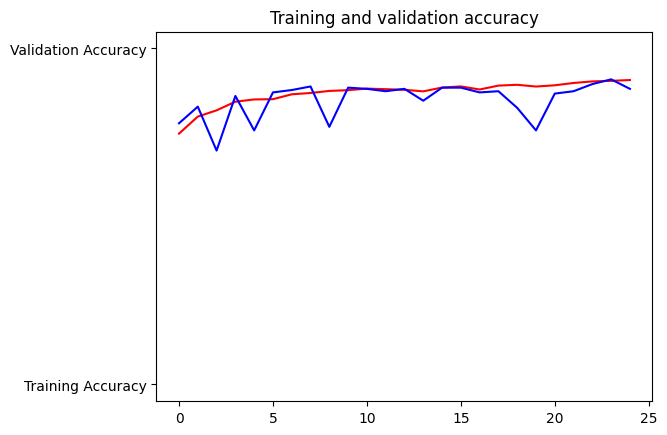

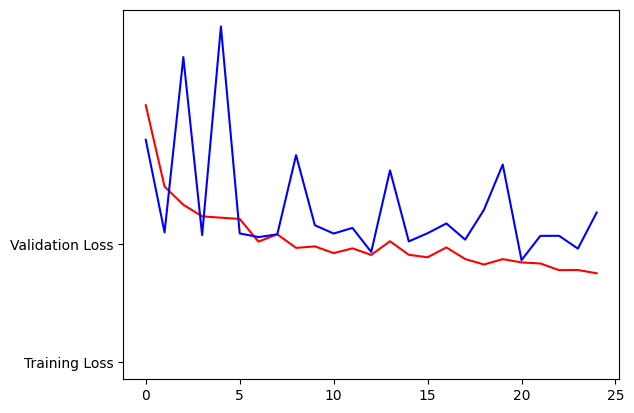

In [16]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

Saving images.jpeg to images.jpeg
1/1 [==============================] - 0s 22ms/step
[-1.3482326]
Defect


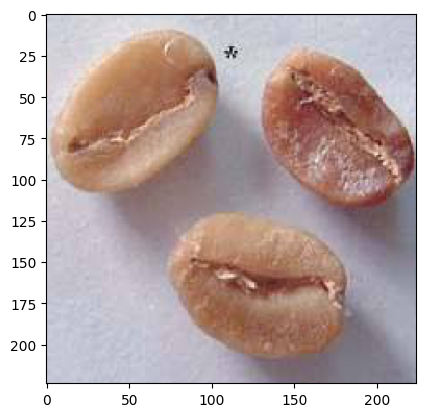

In [22]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
 
#   # predicting images
  path = fn
  img = image.load_img(path, target_size=(224,224))
  imgplot = plt.imshow(img)

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x]) 
  classes = model_tl.predict(images) 
  print(classes[0]) 

if classes[0] < 2.5:
    print('Defect')    
else:
    print('Normal')

In [18]:
import pickle

pickle.dump(model_tl, open('model_tl.pkl','wb'))